In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import time
import json
import scvi
import numpy as np

In [2]:
sc.set_figure_params(figsize=(4, 4))

# Set Params

In [3]:
deep_inject = False
n_epochs_surgery = 300
leave_out_cell_types = ['Pancreas Alpha']

In [4]:
target_batches = ["Pancreas SS2", "Pancreas CelSeq2"]
batch_key = "study"
cell_type_key = "cell_type"

In [5]:
n_epochs_vae = 500
n_epochs_scanvi = 300
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [6]:
# Save right dir path
if deep_inject:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_results/figure_1/scanvi/deep_cond/')
else:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_results/figure_1/scanvi/first_cond/')

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
control_path = f'{dir_path}controlling/'
if not os.path.exists(control_path):
    os.makedirs(control_path)

# Adata Handling

In [7]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_normalized.h5ad'))
adata = adata_all.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 15681 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [8]:
query = np.array([s in target_batches for s in adata.obs[batch_key]])
query_1 = np.array([s in [target_batches[0]] for s in adata.obs[batch_key]])
query_2 = np.array([s in [target_batches[1]] for s in adata.obs[batch_key]])
adata_ref_full = adata[~query].copy()
adata_ref = adata_ref_full[~adata_ref_full.obs[cell_type_key].isin(leave_out_cell_types)].copy()
adata_query_1 = adata[query_1].copy()
adata_query_2 = adata[query_2].copy()

In [9]:
adata_ref

AnnData object with n_obs × n_vars = 7584 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [10]:
adata_query_1

AnnData object with n_obs × n_vars = 2961 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [11]:
adata_query_2

AnnData object with n_obs × n_vars = 2426 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [12]:
scvi.data.setup_anndata(adata_ref, batch_key=batch_key, labels_key=cell_type_key)

INFO      Using batches from adata.obs["study"]                                              
INFO      Using labels from adata.obs["cell_type"]                                           
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 7584 cells, 1000 vars, 3 batches,
          7 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
          extra continuous covariates.                                                       
INFO      Please do not further modify adata until model is trained.                         


# Create SCANVI model and train

In [13]:
vae = scvi.model.SCANVI(
    adata_ref,
    "Unknown",
    n_layers=2,
    use_cuda=True,
    encode_covariates=True,
    deeply_inject_covariates=deep_inject,
    use_layer_norm="both",
    use_batch_norm="none",
    use_observed_lib_size=True,
)

In [14]:
print(adata_ref.obs[cell_type_key].unique().tolist())
print(adata_ref.obs["_scvi_labels"].unique().tolist())
print(adata_ref.obs[batch_key].unique().tolist())
print(adata_ref.obs["_scvi_batch"].unique().tolist())
print("Labelled Indices: ", len(vae._labeled_indices))
print("Unlabelled Indices: ", len(vae._unlabeled_indices))

['Pancreas Endothelial', 'Pancreas Acinar', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Stellate', 'Pancreas Ductal', 'Pancreas Gamma']
[4, 0, 1, 2, 6, 3, 5]
['Pancreas inDrop', 'Pancreas CelSeq', 'Pancreas Fluidigm C1']
[2, 0, 1]
Labelled Indices:  7584
Unlabelled Indices:  0


In [15]:
ref_time = time.time()
vae.train(
    n_epochs_unsupervised=n_epochs_vae,
    n_epochs_semisupervised=n_epochs_scanvi,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)
ref_time = time.time() - ref_time

INFO      Training Unsupervised Trainer for 500 epochs.                                      
INFO      Training SemiSupervised Trainer for 300 epochs.                                    
INFO      KL warmup for 400 epochs                                                           
Training...:   0%|          | 0/500 [00:00<?, ?it/s]

/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Training...:  32%|███▏      | 159/500 [01:27<03:00,  1.89it/s]INFO                                                                                         
          Stopping early: no improvement of more than 0 nats in 10 epochs                    
INFO      If the early stopping criterion is too strong, please instantiate it with different
          parameters in the train method.                                                    
Training...:  32%|███▏      | 159/500 [01:27<03:08,  1.81it/s]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  60 s. / 500 epochs                                                 
INFO      KL warmup phase exceeds overall training phaseIf your applications rely on the     
          posterior quality, consider training for more epochs or reducing the kl warmup.    
INFO      KL warmup for 400 e

# Reference Evaluation

In [16]:
ref_predictions = vae.predict(adata_ref)
adata_ref.obsm["X_scANVI"] = vae.get_latent_representation()
adata_ref.obs["predictions"] = vae.predict()
print("Acc: {}".format(np.mean(ref_predictions == adata_ref.obs[cell_type_key])))

Acc: 0.9671677215189873


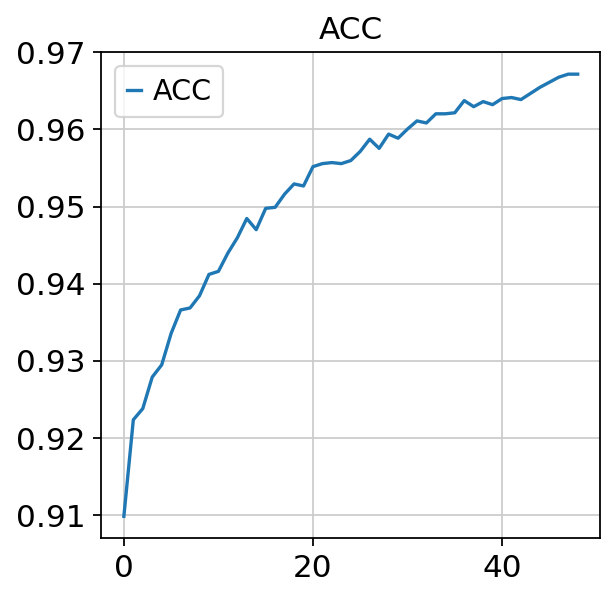

In [17]:
plt.figure()
plt.plot(vae.trainer.history['accuracy_full_dataset'][2:], label="ACC")
plt.title("ACC")
plt.legend()
plt.savefig(f'{control_path}reference_acc.png', bbox_inches='tight')

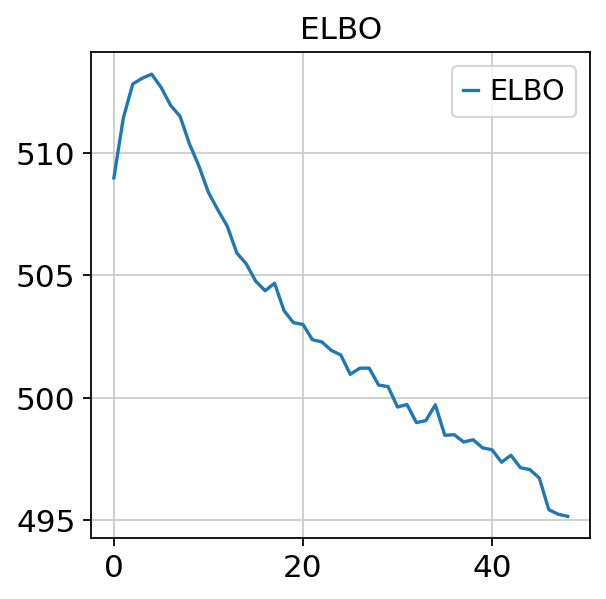

In [18]:
plt.figure()
plt.plot(vae.trainer.history['elbo_full_dataset'][2:], label="ELBO")
plt.title("ELBO")
plt.legend()
plt.savefig(f'{control_path}reference_elbo.png', bbox_inches='tight')

In [19]:
ref_cropped = sc.AnnData(adata_ref.obsm["X_scANVI"])
ref_cropped.obs["celltype"] = adata_ref.obs[cell_type_key].tolist()
ref_cropped.obs["batch"] = adata_ref.obs[batch_key].tolist()
ref_cropped.obs["predictions"] = adata_ref.obs["predictions"].tolist()

In [20]:
sc.pp.neighbors(ref_cropped)
sc.tl.leiden(ref_cropped)
sc.tl.umap(ref_cropped)
ref_cropped.write_h5ad(filename=f'{dir_path}reference_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


In [21]:
ref_cropped

AnnData object with n_obs × n_vars = 7584 × 10
    obs: 'celltype', 'batch', 'predictions', 'leiden'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

<Figure size 320x320 with 0 Axes>

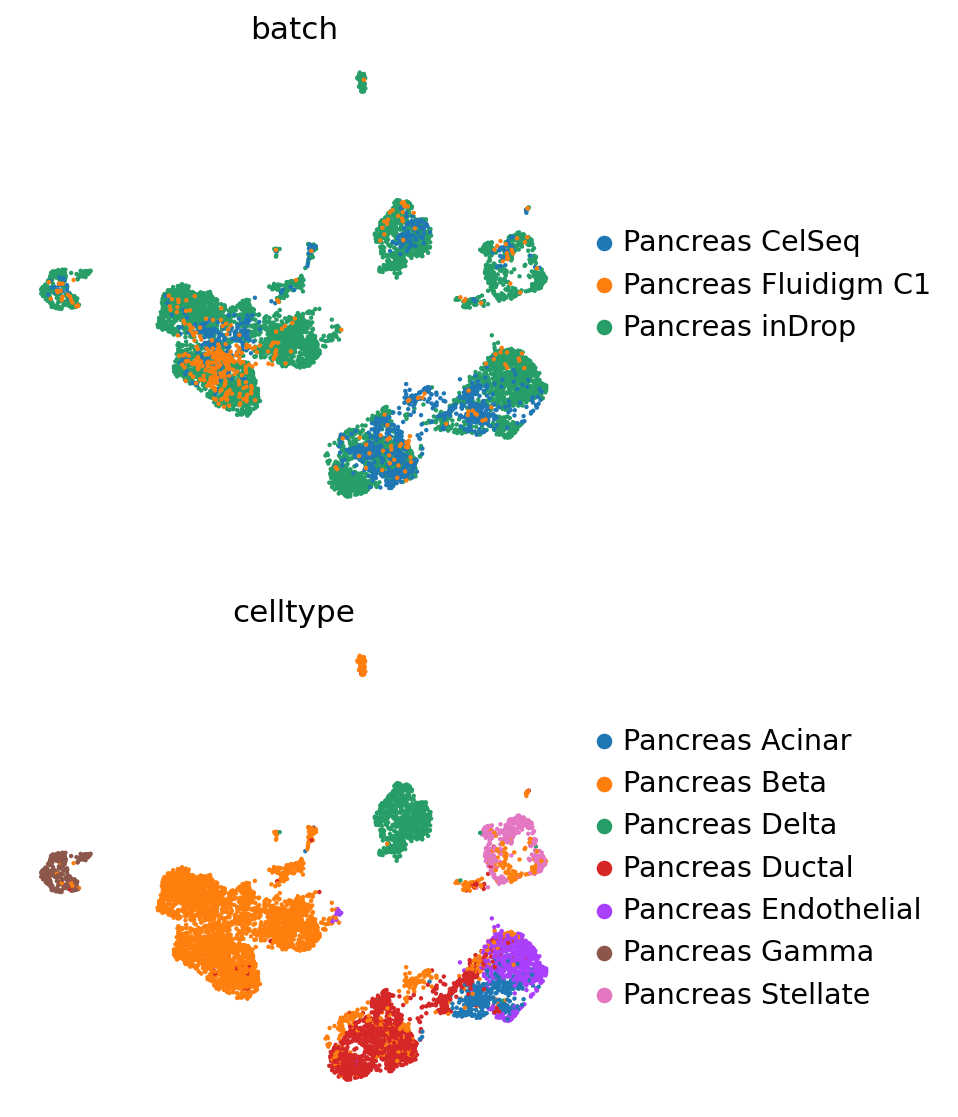

In [22]:
plt.figure()
sc.pl.umap(
    ref_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_reference.png', bbox_inches='tight')

In [23]:
torch.save(vae.model.state_dict(), f'{dir_path}reference_model_state_dict')
ref_path = f'{dir_path}ref_model/'
if not os.path.exists(ref_path):
    os.makedirs(ref_path)
vae.save(ref_path, overwrite=True)

# Run surgery on first query batch

In [24]:
model_1 = scvi.model.SCANVI.load_query_data(
    adata_query_1,
    ref_path,
    use_cuda=True,
    freeze_dropout = True,
    freeze_expression = True,
    freeze_decoder_first_layer = True,
    freeze_batchnorm_encoder = True,
    freeze_batchnorm_decoder = True,
    freeze_classifier = False,
)

INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']    
INFO      Successfully registered anndata object containing 2961 cells, 1000 vars, 4 batches,
          8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
          extra continuous covariates.                                                       


In [25]:
print(adata_query_1.obs[cell_type_key].unique().tolist())
print(adata_query_1.obs["_scvi_labels"].unique().tolist())
print(adata_query_1.obs[batch_key].unique().tolist())
print(adata_query_1.obs["_scvi_batch"].unique().tolist())
model_1._unlabeled_indices = np.arange(adata_query_1.n_obs)
model_1._labeled_indices = []
print("Labelled Indices: ", len(model_1._labeled_indices))
print("Unlabelled Indices: ", len(model_1._unlabeled_indices))

['Pancreas Beta', 'Pancreas Acinar', 'Pancreas Gamma', 'Pancreas Alpha', 'Pancreas Ductal', 'Pancreas Delta', 'Pancreas Stellate', 'Pancreas Endothelial']
[1, 0, 5, 7, 3, 2, 6, 4]
['Pancreas SS2']
[3]
Labelled Indices:  0
Unlabelled Indices:  2961


In [26]:
query_1_time = time.time()
model_1.train(
    n_epochs_semisupervised=n_epochs_surgery,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy"], 
                                       weight_decay=0
                                      ),
    frequency=1
)
query_1_time = time.time() - query_1_time

INFO      Training Unsupervised Trainer for 400 epochs.                                      
INFO      Training SemiSupervised Trainer for 300 epochs.                                    
INFO      KL warmup phase exceeds overall training phaseIf your applications rely on the     
          posterior quality, consider training for more epochs or reducing the kl warmup.    
INFO      KL warmup for 400 epochs                                                           
Training...: 100%|██████████| 300/300 [02:01<00:00,  2.47it/s]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  79 s. / 300 epochs                                                 


# Evaluation Surgery on Query1

In [27]:
adata_query_1.obsm["X_scANVI"] = model_1.get_latent_representation()
adata_query_1.obs["predictions"] = model_1.predict()
query_1_predictions = model_1.predict()
print("Acc: {}".format(np.mean(query_1_predictions == adata_query_1.obs[cell_type_key])))

Acc: 0.49442755825734547


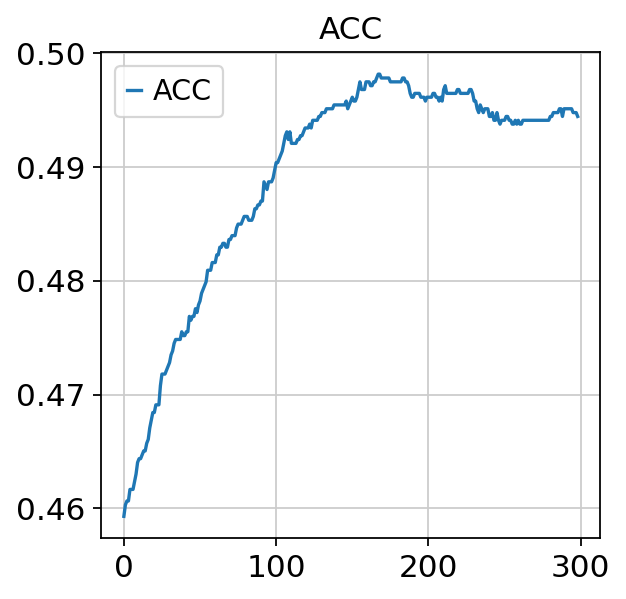

In [28]:
plt.figure()
plt.plot(model_1.trainer.history['accuracy_full_dataset'][2:], label="ACC")
plt.title("ACC")
plt.legend()
plt.savefig(f'{control_path}surgery_acc.png', bbox_inches='tight')

In [29]:
q1_cropped = sc.AnnData(adata_query_1.obsm["X_scANVI"])
q1_cropped.obs["celltype"] = adata_query_1.obs[cell_type_key].tolist()
q1_cropped.obs["batch"] = adata_query_1.obs[batch_key].tolist()
q1_cropped.obs["predictions"] = adata_query_1.obs["predictions"].tolist()

In [30]:
sc.pp.neighbors(q1_cropped)
sc.tl.leiden(q1_cropped)
sc.tl.umap(q1_cropped)
q1_cropped.write_h5ad(filename=f'{dir_path}query_1_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

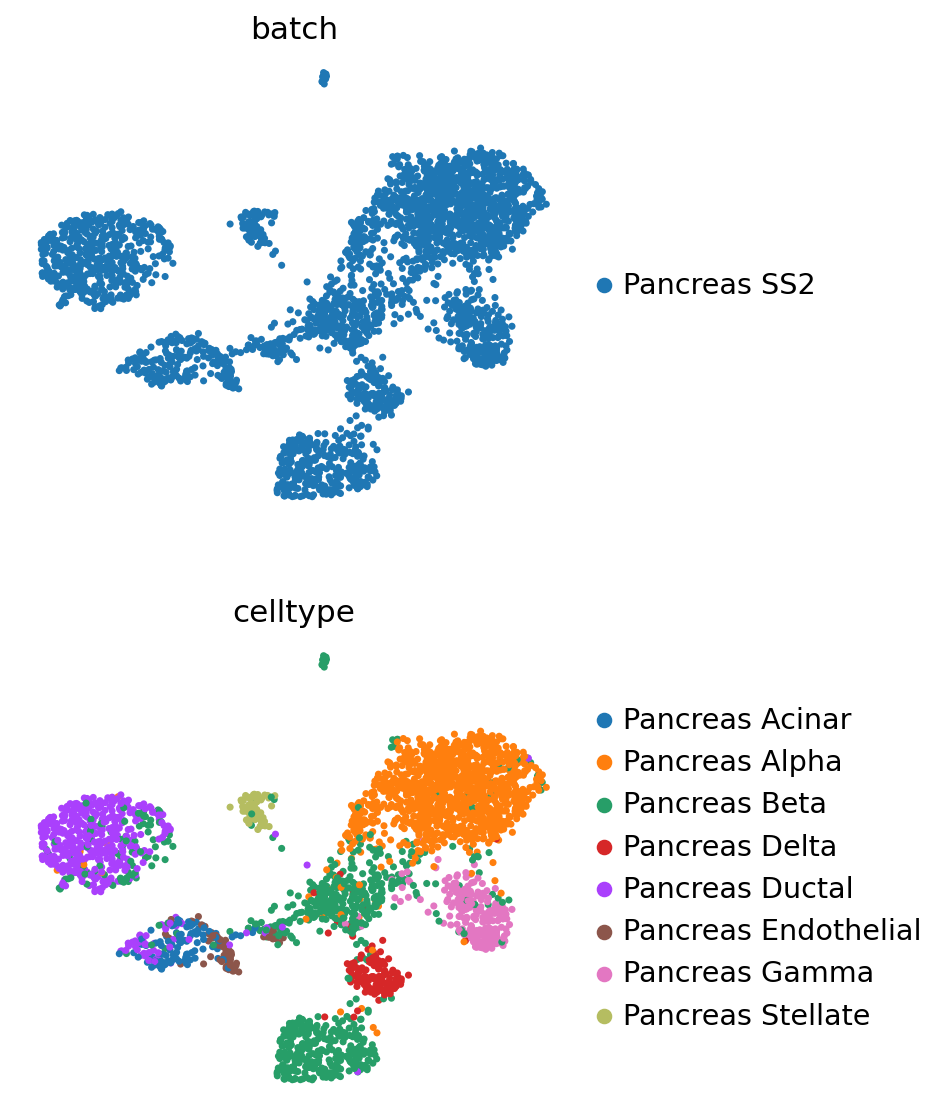

In [31]:
plt.figure()
sc.pl.umap(
    q1_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_query_1.png', bbox_inches='tight')

# Evaluation Query1 on reference

In [32]:
adata_full_1 = adata_ref.concatenate(adata_query_1)
adata_full_1.uns["_scvi"] = adata_query_1.uns["_scvi"]
print(adata_full_1.obs[cell_type_key].unique().tolist())
print(adata_full_1.obs["_scvi_labels"].unique().tolist())
print(adata_full_1.obs[batch_key].unique().tolist())
print(adata_full_1.obs["_scvi_batch"].unique().tolist())
adata_full_1.obsm["X_scANVI"] = model_1.get_latent_representation(adata=adata_full_1)

['Pancreas Endothelial', 'Pancreas Acinar', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Stellate', 'Pancreas Ductal', 'Pancreas Gamma', 'Pancreas Alpha']
[4, 0, 1, 2, 6, 3, 5, 7]
['Pancreas inDrop', 'Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas SS2']
[2, 0, 1, 3]


In [33]:
adata_full_1.obs["predictions"] = model_1.predict(adata_full_1)
full_1_predictions = model_1.predict(adata_full_1)
print("Acc: {}".format(np.mean(full_1_predictions == adata_full_1.obs[cell_type_key])))

Acc: 0.8344238975817924


In [34]:
f1_cropped = sc.AnnData(adata_full_1.obsm["X_scANVI"])
f1_cropped.obs["celltype"] = adata_full_1.obs[cell_type_key].tolist()
f1_cropped.obs["batch"] = adata_full_1.obs[batch_key].tolist()
f1_cropped.obs["predictions"] = adata_full_1.obs["predictions"].tolist()

In [35]:
sc.pp.neighbors(f1_cropped)
sc.tl.leiden(f1_cropped)
sc.tl.umap(f1_cropped)
f1_cropped.write_h5ad(filename=f'{dir_path}full_1_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

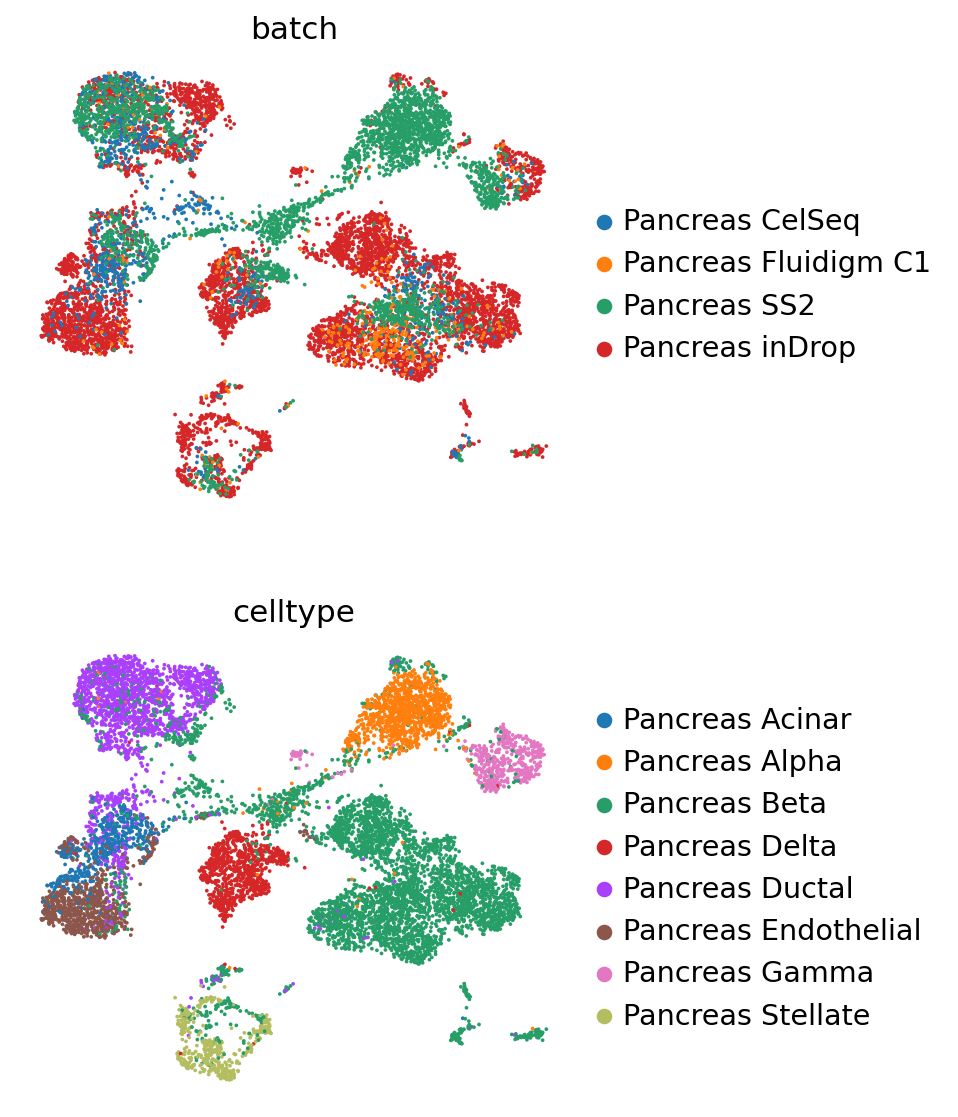

In [36]:
plt.figure()
sc.pl.umap(
    f1_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_full_1.png', bbox_inches='tight')

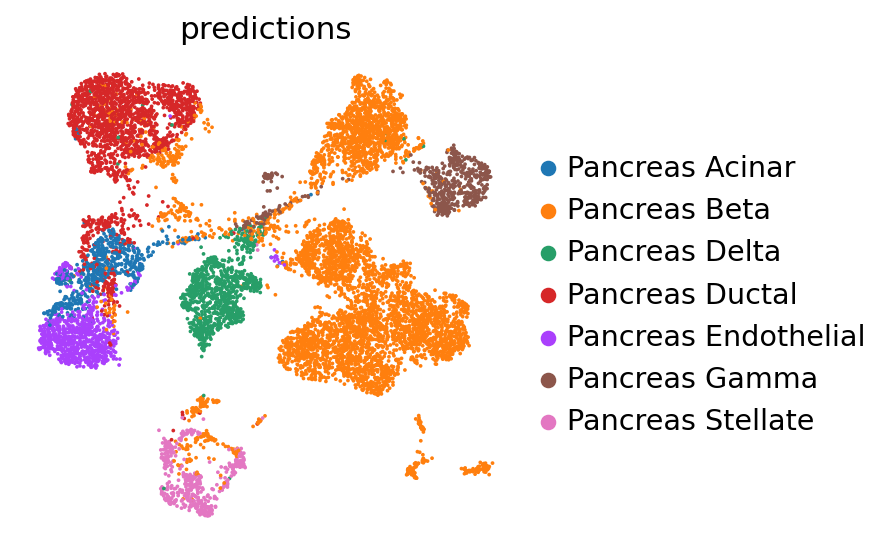

In [37]:
sc.pl.umap(
    f1_cropped,
    color=["predictions"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}pred_full_1.png', bbox_inches='tight')

In [38]:
torch.save(model_1.model.state_dict(), f'{dir_path}surgery_1_model_state_dict')
surgery_1_path = f'{dir_path}surg_1_model/'
if not os.path.exists(surgery_1_path):
    os.makedirs(surgery_1_path)
model_1.save(surgery_1_path, overwrite=True)

# Run surgery on second query batch

In [39]:
model_2 = scvi.model.SCANVI.load_query_data(
    adata_query_2,
    surgery_1_path,
    use_cuda=True,
    freeze_dropout = True,
    freeze_expression = True,
    freeze_decoder_first_layer = True,
    freeze_batchnorm_encoder = True,
    freeze_batchnorm_decoder = True,
    freeze_classifier = False,
)

INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']    
INFO      Successfully registered anndata object containing 2426 cells, 1000 vars, 5 batches,
          8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
          extra continuous covariates.                                                       
WARNING   Make sure the registered X field in anndata contains unnormalized count data.      


/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/scvi/data/_anndata.py:795: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


In [40]:
print(adata_query_2.obs[cell_type_key].unique().tolist())
print(adata_query_2.obs["_scvi_labels"].unique().tolist())
print(adata_query_2.obs[batch_key].unique().tolist())
print(adata_query_2.obs["_scvi_batch"].unique().tolist())
model_2._unlabeled_indices = np.arange(adata_query_2.n_obs)
model_2._labeled_indices = []
print("Labelled Indices: ", len(model_2._labeled_indices))
print("Unlabelled Indices: ", model_2._unlabeled_indices.shape[0])

['Pancreas Alpha', 'Pancreas Delta', 'Pancreas Beta', 'Pancreas Ductal', 'Pancreas Acinar', 'Pancreas Gamma', 'Pancreas Endothelial', 'Pancreas Stellate']
[7, 2, 1, 3, 0, 5, 4, 6]
['Pancreas CelSeq2']
[4]
Labelled Indices:  0
Unlabelled Indices:  2426


In [41]:
query_2_time = time.time()
model_2.train(
    n_epochs_semisupervised=n_epochs_surgery,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy"],
                                       weight_decay=0),
    frequency=1
)
query_2_time = time.time() - query_2_time

INFO      Training Unsupervised Trainer for 400 epochs.                                      
INFO      Training SemiSupervised Trainer for 300 epochs.                                    
INFO      KL warmup phase exceeds overall training phaseIf your applications rely on the     
          posterior quality, consider training for more epochs or reducing the kl warmup.    
INFO      KL warmup for 400 epochs                                                           
Training...:   0%|          | 0/300 [00:00<?, ?it/s]

/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Training...: 100%|██████████| 300/300 [01:39<00:00,  3.00it/s]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  64 s. / 300 epochs                                                 


# Evaluation Surgery on Query2

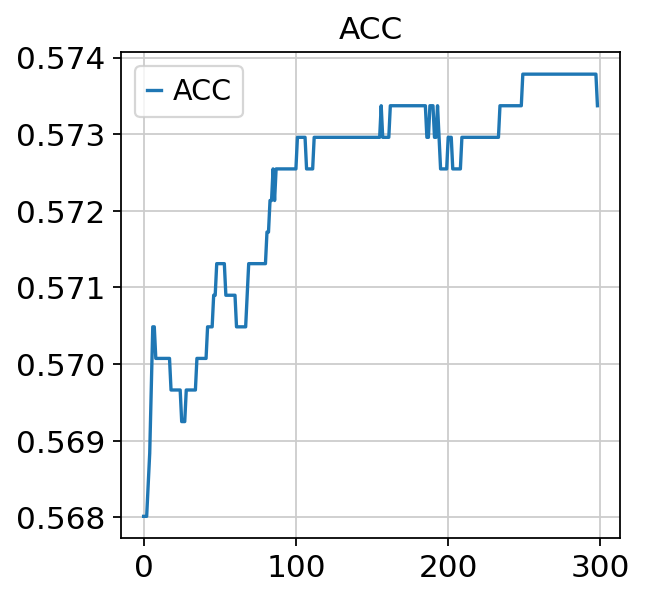

In [42]:
plt.plot(model_2.trainer.history['accuracy_full_dataset'][2:], label="ACC")
plt.title("ACC")
plt.legend()
plt.savefig(f'{control_path}surgery_2_acc.png', bbox_inches='tight')

In [43]:
adata_query_2.obsm["X_scANVI"] = model_2.get_latent_representation()
adata_query_2.obs["predictions"] = model_2.predict()
query_predictions = model_2.predict()
print("Acc: {}".format(np.mean(query_predictions == adata_query_2.obs[cell_type_key])))

WARNING   Make sure the registered X field in anndata contains unnormalized count data.      
WARNING   Make sure the registered X field in anndata contains unnormalized count data.      
WARNING   Make sure the registered X field in anndata contains unnormalized count data.      
Acc: 0.5733718054410553


In [44]:
q2_cropped = sc.AnnData(adata_query_2.obsm["X_scANVI"])
q2_cropped.obs["celltype"] = adata_query_2.obs[cell_type_key].tolist()
q2_cropped.obs["batch"] = adata_query_2.obs[batch_key].tolist()
q2_cropped.obs["predictions"] = adata_query_2.obs["predictions"].tolist()

In [45]:
sc.pp.neighbors(q2_cropped)
sc.tl.leiden(q2_cropped)
sc.tl.umap(q2_cropped)
q2_cropped.write_h5ad(filename=f'{dir_path}query_2_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

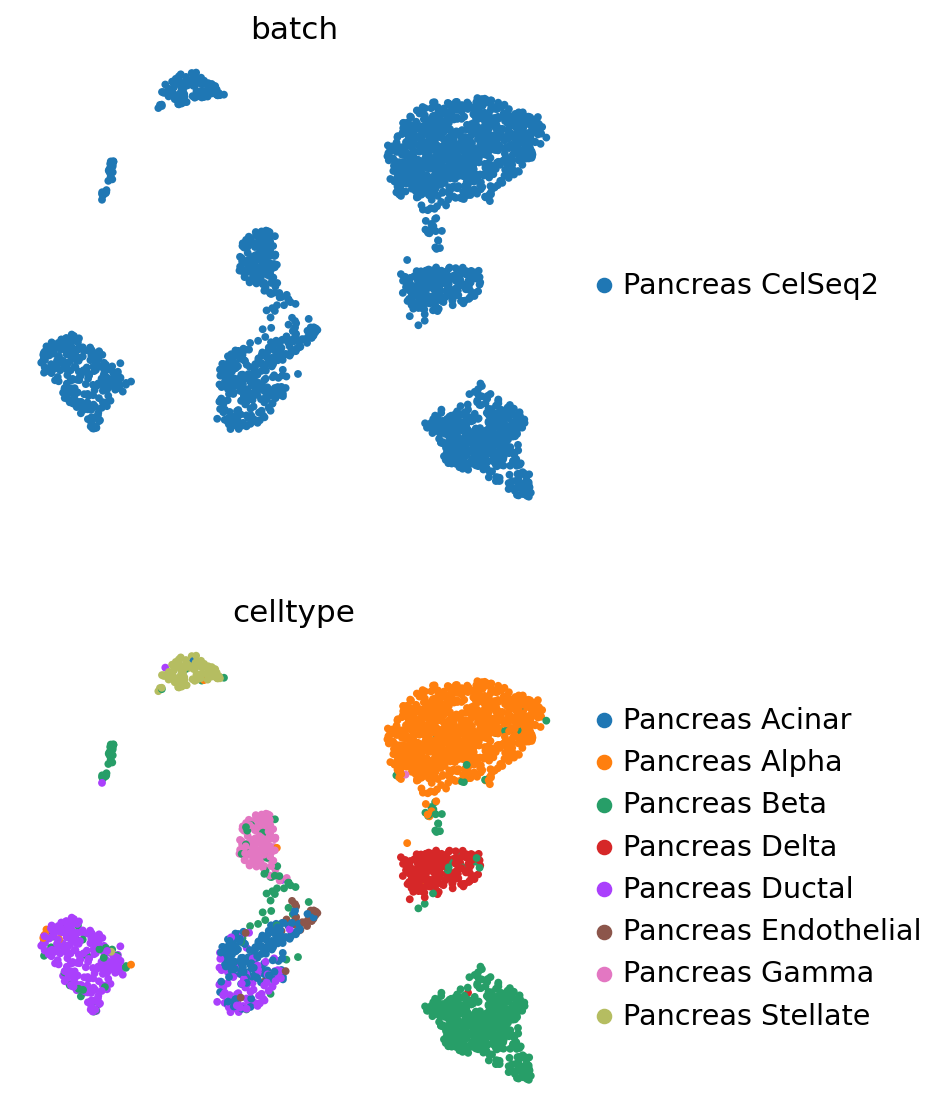

In [46]:
plt.figure()
sc.pl.umap(
    q2_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_query_2.png', bbox_inches='tight')

# Evaluation Query1 and Query2 on Reference

In [47]:
adata_full_2 = adata_full_1.concatenate(adata_query_2)
adata_full_2.uns["_scvi"] = adata_query_2.uns["_scvi"]
print(adata_full_2.obs[cell_type_key].unique().tolist())
print(adata_full_2.obs["_scvi_labels"].unique().tolist())
print(adata_full_2.obs[batch_key].unique().tolist())
print(adata_full_2.obs["_scvi_batch"].unique().tolist())
adata_full_2.obsm["X_scANVI"] = model_2.get_latent_representation(adata=adata_full_2)
adata_full_2.obs["predicitions"] = model_2.predict(adata_full_2)
full_predictions = model_2.predict(adata_full_2)
print("Acc: {}".format(np.mean(full_predictions == adata_full_2.obs[cell_type_key])))

['Pancreas Endothelial', 'Pancreas Acinar', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Stellate', 'Pancreas Ductal', 'Pancreas Gamma', 'Pancreas Alpha']
[4, 0, 1, 2, 6, 3, 5, 7]
['Pancreas inDrop', 'Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas SS2', 'Pancreas CelSeq2']
[2, 0, 1, 3, 4]
Acc: 0.7855986431269756


In [48]:
f2_cropped = sc.AnnData(adata_full_2.obsm["X_scANVI"])
f2_cropped.obs["celltype"] = adata_full_2.obs[cell_type_key].tolist()
f2_cropped.obs["batch"] = adata_full_2.obs[batch_key].tolist()
f2_cropped.obs["predictions"] = adata_full_2.obs["predictions"].tolist()

In [49]:
sc.pp.neighbors(f2_cropped)
sc.tl.leiden(f2_cropped)
sc.tl.umap(f2_cropped)
f2_cropped.write_h5ad(filename=f'{dir_path}full_2_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

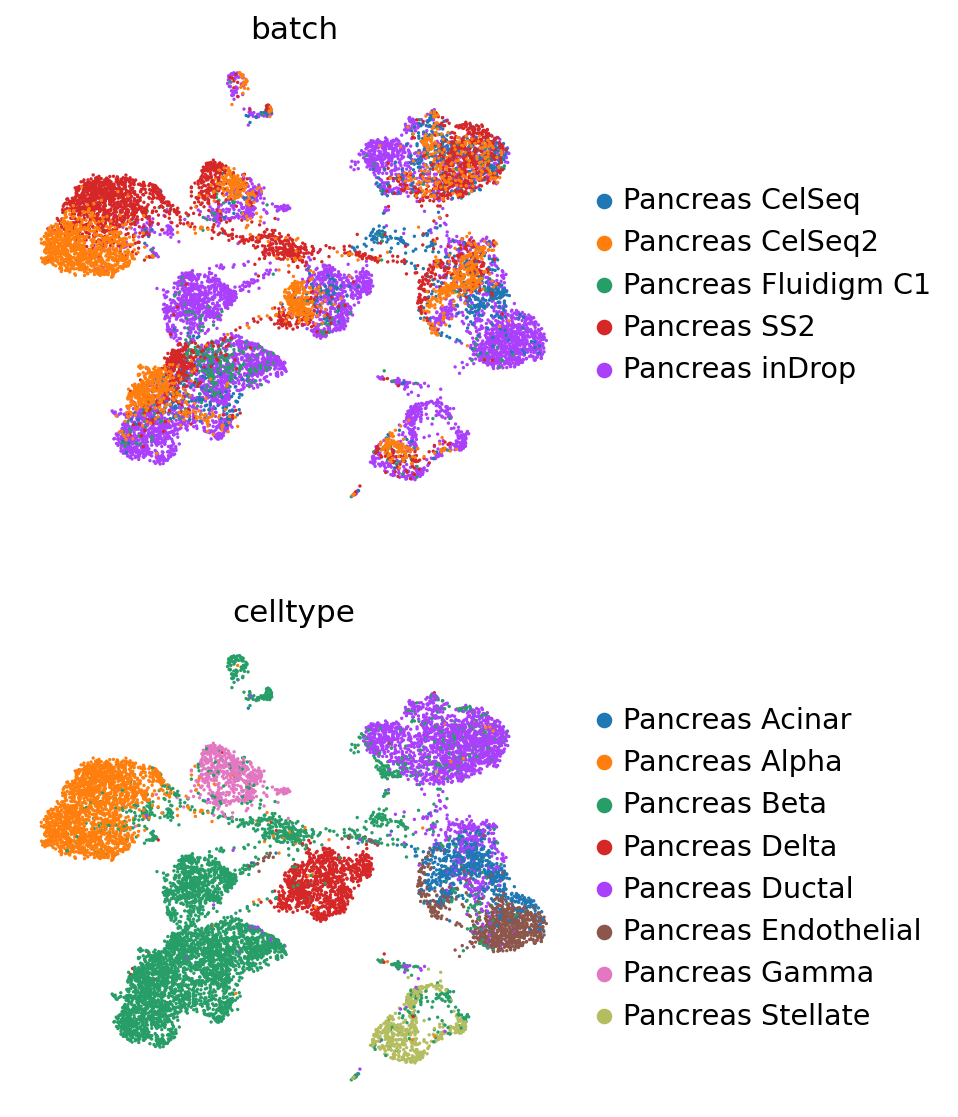

In [50]:
plt.figure()
sc.pl.umap(
    f2_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_full_2.png', bbox_inches='tight')

<Figure size 320x320 with 0 Axes>

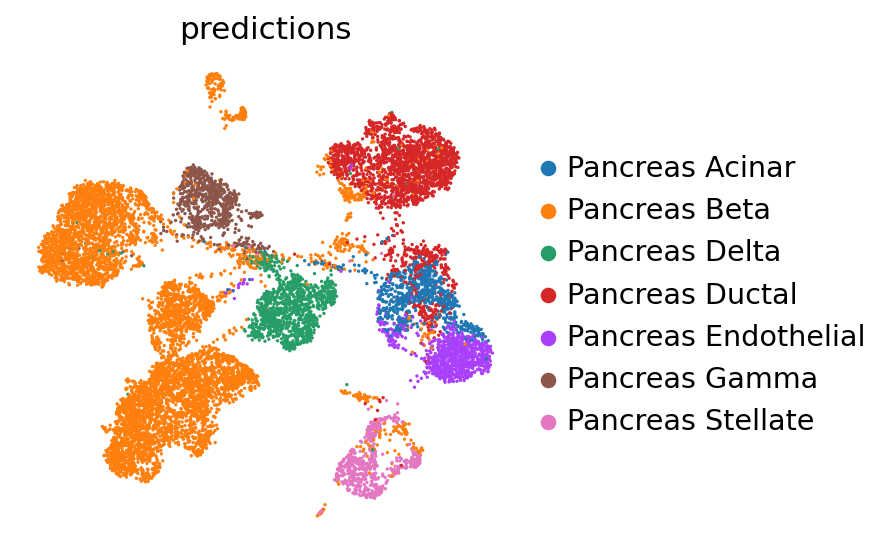

In [51]:
plt.figure()
sc.pl.umap(
    f2_cropped,
    color=["predictions"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}pred_full_2.png', bbox_inches='tight')

In [52]:
torch.save(model_2.model.state_dict(), f'{dir_path}surgery_2_model_state_dict')
surgery_2_path = f'{dir_path}surg_2_model/'
if not os.path.exists(surgery_2_path):
    os.makedirs(surgery_2_path)
model_2.save(surgery_2_path, overwrite=True)

In [53]:
times = dict()
times["ref_time"] = ref_time
times["query_1_time"] = query_1_time
times["query_2_time"] = query_2_time
times["full_time"] = ref_time + query_1_time + query_2_time
with open(f'{dir_path}results_times.txt', 'w') as filehandle:
    json.dump(times, filehandle)